## Financial Statement Audit: Discretionary Total Accruals

By Varun Ganti

## Table of Contents

- [Problem Statement](#Problem-Statemet)
- [Executive Summary](#Executive-Summary)
- [Data Dictionary](#Data-Dictionary)
- [Loading Data](#Loading-Data)
- [Data Cleaning](#Data-Cleaning)
- [Feature Engineering](#Feature-Engineering)
- [EDA](#EDA)
- [Model Preparation](#Model-Preparation)
- [Model Selection](#Model-Selection)
-
- [Conclusion](#Model-Selection)
- [Recommendations](#Reccomendations)
- [Resources](#Resources)



## Problem Statement

During election time, we see the amount of restatements on accruals go up for company, Accrual accounting is required by GAAP and companies have to spend loads of money to adapt to these standards. Our team wants to create various predictive models, such as linear regression, ridge, knn, decision trees, bagging, boosting, and random forests to predict the amount of discretionary accruals for a company, so we can plan the audit process accordingly. The metric to determine which model we deploy during our audit is R2, which will show how much our models explain the variance in the data. We chose to mirror the Jones Model is in order to predict the total net accruals for a company. This model is going to input variables from 2016 Q1-Q4 data into the regression model. After We create the model, we are going to train the model on a prior period data. After choosing the model with the highest r2, we are going to use the model to validate the model on the next period(2017 Q3).


# Executive Summary

Our team found that the data is readily avaliable on the SEC website with published quarterly financial statments. From our previous audit process, we hypothesized that the difference between the change in revenue and the change in recievables, and the book value of property plant and equipment variables would have the most influence over predicting total accruals. The difference of revenue and recievables will show the amount of income recieved by a company that is not based on recievables(cash). The abundance of variables, forced me to dive deeper into the data in order to find the most optimal combinations in order to find the highest scoring model. We want a high majority of the data to be explained by our model. 


EDA helped our team drastically not only set up a preprocessing plan for our model, but helped us understand the health of the data One example was that “NetCashOperating” showed up high on the correlation heat map, meaning that this variable will be useful in predicting total net accruals. For preprocessing, we chose to drop all null values with na, assuming that those values actually reperesented none of that type. Most of our eda consisted of examining the financial statmenets, and engineer features accordingly to fit our model. We decided to log all numeric columns to normalize the distributions. Furthermore, we had to create lagged variables in order to find the differences of sales and recievables from the prior quarter. On top of that, we needed to engineer our target variable based on the difference between net income and net cash from operating activities. The way companies transition from cash to accrual basis is to find the differences between assets and liabilities and either add that to cash income or subtract from accruals.  

|Model|Type|Train R2|Testing R2|
|---|---|---|---|
|**Model 1**|*Linear*|0.886|0.762| 
|**Model 2**|*Ridge*|.883|0.757|
|**Model 4**|*KNN Regressor*|.0.816|.712|
|**Model 5**|*Decision Trees*|.0.772|.677|
|**Model 6**|*Bagged Decision Trees*|.816|.708|
|**Model 7**|*Random Forrest Trees*|.812|.719|
|**Model 8**|*SVM*|.8251|.5878|

Our approach to picking the best model, is by assessing the R2 Score and the cross validation score on the whole data set. We decided to deploy our linear model into the the audit process because of the ability to examine coeficients and continously improve our model. Once given more time, we can examine non cash activites such as depreciation to see how that can affect accruals

## Data Dictionary

Refer to Sec for Data Description

- [Description of SEC Data](file:///Users/varunganti/Downloads/2017q1/readme.htm)

## Loading Data

In [615]:
import pandas as pd
from sklearn import linear_model
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
import warnings
warnings.filterwarnings("ignore") # Shhhh
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import mean_squared_error
import seaborn as sns
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from math import sqrt
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import BaggingRegressor, RandomForestRegressor, AdaBoostRegressor
from sklearn.metrics import mean_squared_error, f1_score
from sklearn import svm
from sklearn.linear_model import RidgeCV
from sklearn.linear_model import LassoCV
from sklearn.pipeline import Pipeline
from sklearn.dummy import DummyRegressor
%matplotlib inline

#### SEC given Data          
          
          SUB – Submission data set; this includes one record for each XBRL submission. The set includes fields of information pertinent to the submission and the filing entity. Information is extracted from the SEC’s EDGAR system and the filings submitted to the SEC by registrants.

    ·     NUM – Number data set; this includes one row for each distinct amount from each submission included in the SUB data set. The Number data set includes, for every submission, for each primary financial statement as it is rendered by the SEC Viewer/Previewer, all line item values.

    ·     TAG – Tag data set; includes defining information about each tag.  Information includes tag descriptions (documentation labels), taxonomy version information and other tag attributes.

    ·     PRE – Presentation data set; this provides information about how the tags and numbers were presented in the primary financial statements.

In [316]:
num1 =  pd.read_csv('./data/2016q1/num.txt', sep = '\t', encoding="latin-1")
tag1 =  pd.read_csv('./data/2016q1/tag.txt', sep = '\t', encoding="latin-1")
pre1 =  pd.read_csv('./data/2016q1/pre.txt', sep = '\t', encoding="latin-1")
sub1 =  pd.read_csv('./data/2016q1/sub.txt', sep = '\t', encoding="latin-1")

## Data Cleaning

#### Understanding our data. Part of Audit Planning


1.SUB is identifies all the EDGAR submissions in the data set, with each row having the unique (primary) key adsh,  a 20 character EDGAR Accession Number with dashes in positions 11 and 14.

2.TAG is a data set of all tags used in the submissions, both standard and custom.  A unique key of each row is a combination of these fields:

     1)    tag – tag used by the filer

     2)    version – if a standard tag, the taxonomy of origin, otherwise equal to adsh.


3.NUM is a data set of all numeric XBRL facts presented on the primary financial statements. A unique key of each row is a combination of the following fields:

     1)    adsh- EDGAR accession number

     2)    tag – tag used by the filer
    
     3)    version – if a standard tag, the taxonomy of origin, otherwise equal to adsh.

     4)    ddate - period end date

     5)    qtrs - duration in number of quarters

     6)    uom - unit of measure
    
     7)    coreg - coregistrant of the parent company registrant (if applicable)


4.PRE is a data set that provides the text assigned by the filer to each line item in the primary financial statements, the order in which the line item appeared, and the tag assigned to it.  A unique key of each row is a combination of the following fields:

      1)    adsh – EDGAR accession number

      2)    report – sequential number of report within the statements

      3)    line – sequential number of line within a report.
      
We will merge based on the unique identifiers listed above

In [317]:
firstmerge1 = pd.merge(pre1, sub1, how = "left", on=['adsh'])   #left merge
secondmerge1 = pd.merge(firstmerge1, tag1, how= "left", on =['tag', 'version'])
thirdmerge1 = pd.merge(secondmerge1, num1, how = "left", on =['adsh', 'tag', 'version'])
sec_table2015 = thirdmerge1[['cik','adsh' , 'afs' , 'qtrs' , 'fy' , 'fp', 'tag', 'version', 'value' , 'ddate']].sort_values(['cik'])

Create a function that can extract all the tags that are unique and want for our analysis. In this case we want net income, net cash, sales revenue, assets, accounts rec, and property plant eq. These financial tags will help us set up our equation to fit the model

In [318]:
def get_tags(df,tag1,tag2,tag3,tag4,tag5,tag6):

    Regression_2015 = df[(df.tag == tag1)
                        | (df.tag == tag2)
                        | (df.tag == tag3)
                        | (df.tag == tag4)
                        | (df.tag == tag5)
                        | (df.tag == tag6)]
    return Regression_2015

In [319]:
Regression_2015 = get_tags(sec_table2015,'NetIncomeLoss','NetCashProvidedByUsedInOperatingActivities','SalesRevenueNet','Assets',
'AccountsReceivableNetCurrent','PropertyPlantAndEquipmentNet')

Create a pivot table based on the amount of quarters to see where the values are listed

In [320]:
Regression_2015.pivot_table(values='value', index=['tag', 'adsh','cik','ddate'], columns=['qtrs'])

qtrs                                                                        0.0    \
tag                          adsh                 cik     ddate                     
AccountsReceivableNetCurrent 0000002178-16-000064 2178    20141231.0  144434000.0   
                                                          20151231.0   71813000.0   
                             0000002488-16-000111 2488    20141231.0  818000000.0   
                                                          20151231.0  533000000.0   
                             0000003545-16-000130 3545    20150930.0    3137000.0   
...                                                                           ...   
SalesRevenueNet              0001391609-16-000415 1223533 20151231.0          NaN   
                             0001437749-16-028714 1322439 20150331.0          NaN   
                                                          20150630.0          NaN   
                                                          20150930.0          NaN   
                                                          20151231.0          NaN   

qtrs                                                                       1.0    \
tag                          adsh                 cik     ddate                    
AccountsReceivableNetCurrent 0000002178-16-000064 2178    20141231.0         NaN   
                                                          20151231.0         NaN   
                             0000002488-16-000111 2488    20141231.0         NaN   
                                                          20151231.0         NaN   
                             0000003545-16-000130 3545    20150930.0         NaN   
...                                                                          ...   
SalesRevenueNet              0001391609-16-000415 1223533 20151231.0         NaN   
                             0001437749-16-028714 1322439 20150331.0  26331166.0   
                                                          20150630.0  22657372.0   
                                                          20150930.0  29127482.0   
                                                          20151231.0  25740856.0   

qtrs                                                                  2.0    \
tag                          adsh                 cik     ddate               
AccountsReceivableNetCurrent 0000002178-16-000064 2178    20141231.0    NaN   
                                                          20151231.0    NaN   
                             0000002488-16-000111 2488    20141231.0    NaN   
                                                          20151231.0    NaN   
                             0000003545-16-000130 3545    20150930.0    NaN   
...                                                                     ...   
SalesRevenueNet              0001391609-16-000415 1223533 20151231.0    NaN   
                             0001437749-16-028714 1322439 20150331.0    NaN   
                                                          20150630.0    NaN   
                                                          20150930.0    NaN   
                                                          20151231.0    NaN   

qtrs                                                                  3.0    \
tag                          adsh                 cik     ddate               
AccountsReceivableNetCurrent 0000002178-16-000064 2178    20141231.0    NaN   
                                                          20151231.0    NaN   
                             0000002488-16-000111 2488    20141231.0    NaN   
                                                          20151231.0    NaN   
                             0000003545-16-000130 3545    20150930.0    NaN   
...                                                                     ...   
SalesRevenueNet              0001391609-16-000415 1223533 20151231.0    NaN   
                             0001437749-16-028714 1322439 2015

## Feature Engineering

#### Jones Model Modified Equation

$$
\begin{eqnarray}
Y(Total Net Accruals/ ATA) &=& \beta_0 + \beta_1(1/ATA) + \beta_2((Change in Rev - Change in AR) / ATA))+  \beta_3(Property Plant Equipment/ ATA) +\beta_4(NetIncomeLoss/ATA) + \beta_5(NetCashProvidedByUsedInOperatingActivities/ATA) +\varepsilon\\
\end{eqnarray}
$$

Create a function to engineer tags in order to fit equation above. We can multiply through average total assets, but its is useful to engineer a lag variable for assets. Total Net Accruals will equal net income - net cash. To find the change of revenue and change in AR we have to use lag variables and the subtract the current from the prior. Once we accomplish that we can create the change in sales- change in accounts rec column for our equation. We dont need to engineer PP&E as the value on the quarterly statement is in the book value

In [321]:
def engineer_tags(df, datepresent, dateprior):
    data_set = df[(df.ddate == datepresent)
                   | (df.ddate == dateprior)]
    data_table = pd.pivot_table(data_set,
                             values = 'value',
                             index = ['cik','ddate'],
                             columns = 'tag',
                             dropna = True)
    data_table['TotalNetAccruals'] =  data_table['NetIncomeLoss'] - data_table['NetCashProvidedByUsedInOperatingActivities']
    Q_Regression = data_table.dropna(axis = 0)
    Q_Regression['AssetsPrior']=Q_Regression.groupby('cik').Assets.shift()
    Q_Regression['RevPrior'] = Q_Regression.groupby('cik').SalesRevenueNet.shift()
    Q_Regression['ArPrior'] = Q_Regression.groupby('cik').AccountsReceivableNetCurrent.shift()
    Q_Regression['RevChange'] = Q_Regression['SalesRevenueNet'] - Q_Regression['RevPrior']
    Q_Regression['ARChange'] = Q_Regression['AccountsReceivableNetCurrent'] - Q_Regression['ArPrior']
    Q_Regression['ROA'] = Q_Regression['NetIncomeLoss'] / Q_Regression['Assets']
    Q_Regression['ChangeSalesRec'] = Q_Regression['RevChange'] - Q_Regression['ARChange']
    Regression_Q = Q_Regression.dropna(axis = 0)
    return Regression_Q

Call function for all quarters that we want. In this case its Q4,Q3, and Q2. We need to filter out based on date. To note, the engineered function is used only on our modified jones model equation. To generalize a function for all financial statements we can use a tag parameter to be specific

In [322]:
Regression_Q42015 = engineer_tags(Regression_2015, 20151231,20141231)

In [323]:
Regression_Q32015 = engineer_tags(Regression_2015, 20150930,20140930)

In [324]:
Regression_Q22015 = engineer_tags(Regression_2015,20150630, 20140630)

Concat all dataframes to make one data frame for the model. Make sure there are no nans and ensure that we have 410 full observations

In [325]:
df = pd.concat([Regression_Q42015,Regression_Q32015,Regression_Q22015])
df.head()

,tag,AccountsReceivableNetCurrent,Assets,NetCashProvidedByUsedInOperatingActivities,NetIncomeLoss,PropertyPlantAndEquipmentNet,SalesRevenueNet,TotalNetAccruals,AssetsPrior,RevPrior,ArPrior,RevChange,ARChange,ROA,ChangeSalesRec
cik,ddate,,,,,,,,,,,,,,
1800,20151231.0,3.418000e+09,4.124700e+10,2.966000e+09,2.595000e+09,5.730000e+09,1.279650e+10,-371000000.0,4.120700e+10,1.280150e+10,3.586000e+09,-5.000000e+06,-168000000.0,0.062914,1.630000e+08
2488,20151231.0,5.330000e+08,3.109000e+09,-2.260000e+08,-3.810000e+08,1.880000e+08,3.991000e+09,-155000000.0,3.767000e+09,5.506000e+09,8.180000e+08,-1.515000e+09,-285000000.0,-0.122547,-1.230000e+09
7536,20151231.0,6.161418e+09,1.302193e+10,6.550790e+08,3.281090e+08,7.001780e+08,1.501668e+10,-326970000.0,1.243530e+10,1.458278e+10,6.043850e+09,4.339045e+08,117568000.0,0.025197,3.163365e+08
9092,20151231.0,5.664300e+07,3.554800e+08,3.583100e+07,1.571050e+07,9.092000e+07,2.367340e+08,-20120500.0,3.411580e+08,2.270535e+08,5.396700e+07,9.680500e+06,2676000.0,0.044195,7.004500e+06
12208,20151231.0,3.914850e+08,3.711542e+09,1.862100e+08,8.129650e+07,4.376900e+08,1.295020e+09,-104913500.0,3.341278e+09,1.386622e+09,3.776400e+08,-9.160150e+07,13845000.0,0.021904,-1.054465e+08


## EDA

Describe each numeric column and its descriptive stats

In [326]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
tag,,,,,,,,
AccountsReceivableNetCurrent,410.0,3.505436e+08,8.977213e+08,0.000000e+00,8.937700e+06,6.307350e+07,2.551132e+08,6.423000e+09
Assets,410.0,4.102572e+09,1.095470e+10,9.263300e+04,1.178199e+08,6.236960e+08,2.518572e+09,8.170300e+10
NetCashProvidedByUsedInOperatingActivities,410.0,4.151233e+08,1.526400e+09,-7.898840e+08,8.320448e+05,4.118150e+07,2.013768e+08,2.032900e+10
NetIncomeLoss,410.0,1.302900e+08,9.138933e+08,-7.829000e+09,-7.894000e+06,7.356000e+06,7.773400e+07,1.139550e+10
PropertyPlantAndEquipmentNet,410.0,1.346942e+09,5.818129e+09,4.530000e+03,8.986007e+06,8.840950e+07,5.383000e+08,5.951000e+10
SalesRevenueNet,410.0,2.139220e+09,6.448746e+09,2.527700e+04,7.235975e+07,3.747610e+08,1.317214e+09,7.137650e+10
TotalNetAccruals,410.0,-2.848332e+08,1.111460e+09,-1.138100e+10,-1.428844e+08,-2.803375e+07,-1.905370e+06,1.896800e+09
AssetsPrior,410.0,3.899279e+09,1.040256e+10,3.890600e+04,1.049255e+08,5.733129e+08,2.276154e+09,7.812700e+10
RevPrior,410.0,2.206297e+09,6.647287e+09,-1.289950e+05,6.180688e+07,3.603220e+08,1.362438e+09,5.915800e+10


#### Analysis of Descriptive Statistics

One balance sheet item that stuck out to our audit team, is that the min AR is 0 for a company. This means that the company with $0 has no recievables on its books. For a big public company, to not have any recievables on their book is very unique and must mean that all of their revenue comes in cash. This could be a high inventory company who sells its inventory for cash. 

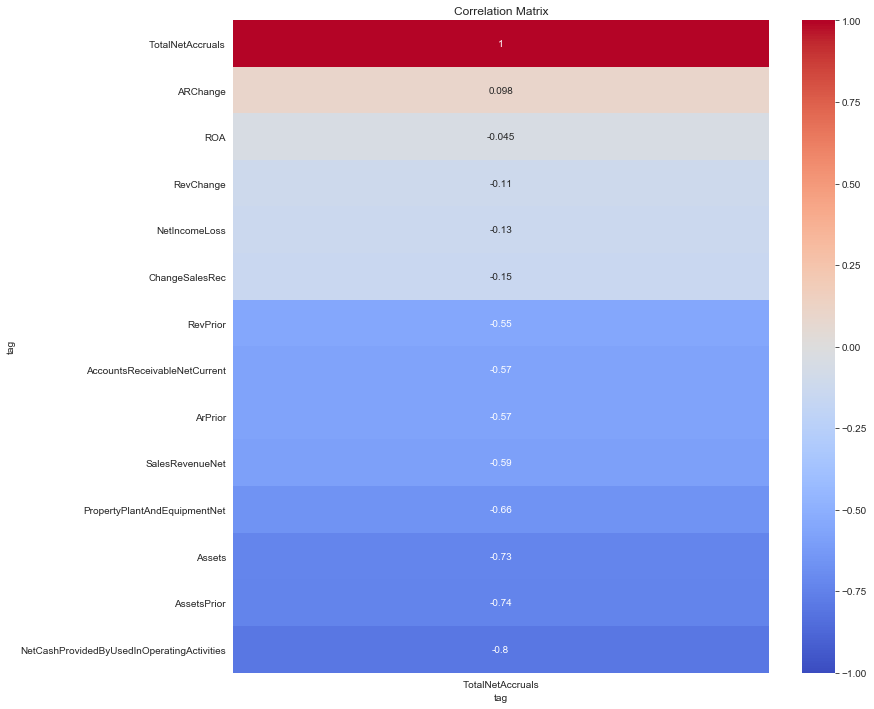

In [327]:
plt.figure(figsize= (12,12))
plt.title("Correlation Matrix")
sns.heatmap(df.corr()[['TotalNetAccruals']].sort_values('TotalNetAccruals', ascending = False), 
            annot = True, cmap = "coolwarm", vmax = 1, vmin = -1)

#### The correlation heat map shows that most of the financial items only have negative correlations with Accruals.

- Net Cash- High negative correlation with Accruals. Makes sense as the amount of cash sales increase then the amount of accruals decrease

- Change Sales Rec- Newly Engineered feature. As the differnece of sales and recievables become larger and larger it shows that more sales are in cash. Makes sense a negative correlation with Total Accruals

- PPE- As the book value for the equipment increases it makes sense that total accruals decrease because depreciation increases which makes expenses more than income. We capatilize ppe as assets, but once we use the equipment it becomes an expense on the books. 

These variables are going to be crucial in learning total accruals. We always want to see the relationships prior to fitting the modekl

Create a function that takes the histogram of all numeric columns in our data set

In [417]:
def inital_hist(df, tag, xlabel,title):
    ax = df[tag].plot(kind = 'hist', title = title
                           , y = "Frequency(units)", bins = 5)
    ax.set_xlabel(xlabel)

We want to see the distribution of Total Accruals in millions.

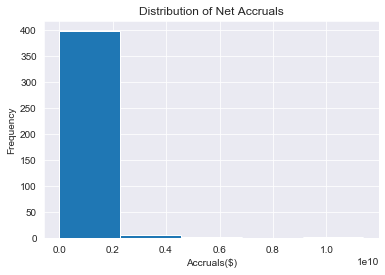

In [418]:
inital_hist(df, 'TotalNetAccruals', "Accruals($)", "Distribution of Net Accruals")

We can see that the distribution is rather skewed, so we should try logging all numeric columns to normalize the distribution of our y variable


Create a function that logs all numeric columns and plots them to show normalized distribution

In [419]:
def log_numeric_column(df, tag, new_column, title, xlabel):

    df[tag] = df[tag].abs()
    df[new_column] = df[tag].apply(np.log)
    ax= df[new_column].plot(kind = 'hist', title = title ,bins = 5)
    ax.set_xlabel(xlabel)

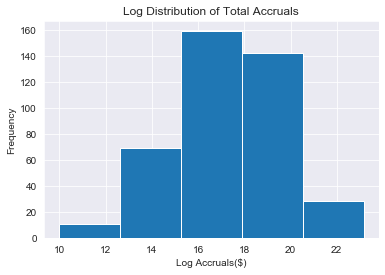

In [421]:
log_numeric_column(df, "TotalNetAccruals", 'TotalAccrualslog', 
                   "Log Distribution of Total Accruals", "Log Accruals($)")

Our distribution normalized and this will be our target variable

We want to do the same for all numeric columns(x variables)

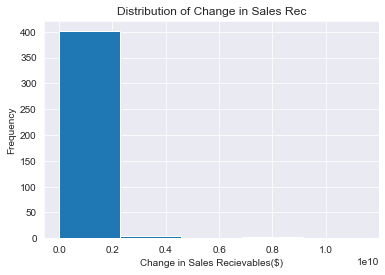

In [422]:
inital_hist(df, 'ChangeSalesRec', "Change in Sales Recievables($)","Distribution of Change in Sales Rec")

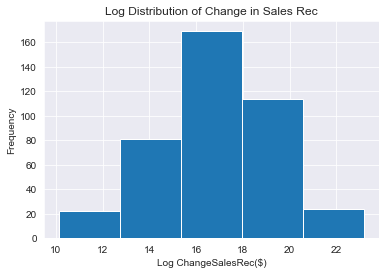

In [423]:
log_numeric_column(df, 'ChangeSalesRec', 'ChangeInSalesRecLog', 
                   "Log Distribution of Change in Sales Rec", "Log ChangeSalesRec($)")

Our distribution normalized and this will be our target variable

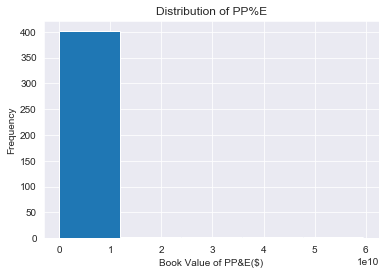

In [424]:
inital_hist(df, 'PropertyPlantAndEquipmentNet', 
            "Book Value of PP&E($)","Distribution of PP%E")

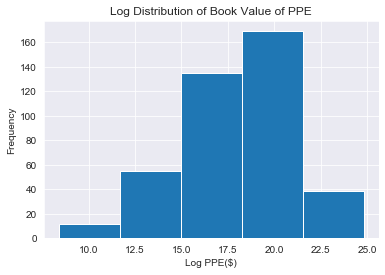

In [426]:
log_numeric_column(df, 'PropertyPlantAndEquipmentNet', 'LogPPE', 
                   "Log Distribution of Book Value of PPE", "Log PPE($)")

Our distribution normalized and this will be our target variable

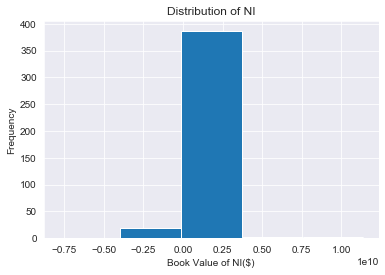

In [427]:
inital_hist(df, 'NetIncomeLoss', 
            "Book Value of NI($)","Distribution of NI")

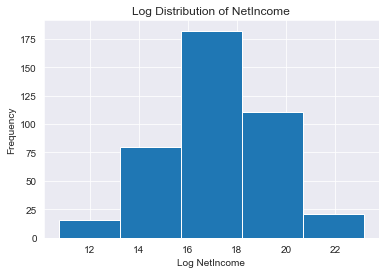

In [428]:
log_numeric_column(df, 'NetIncomeLoss', 'LogNetIncome', 
                   "Log Distribution of NetIncome" , "Log NetIncome($)")

Our distribution normalized and this will be one of our x variables

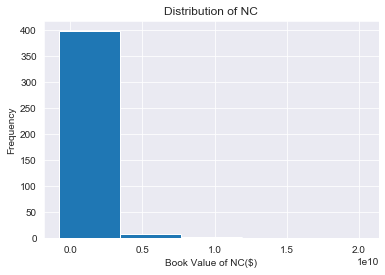

In [430]:
inital_hist(df, 'NetCashProvidedByUsedInOperatingActivities', 
            "Book Value of NC($)","Distribution of NC")

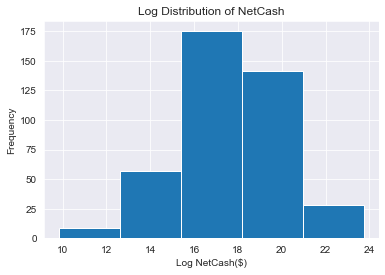

In [431]:
log_numeric_column(df, 'NetCashProvidedByUsedInOperatingActivities', 'LogNetCash', 
                   "Log Distribution of NetCash" , "Log NetCash($)")

Our distribution normalized and this will be one of our x variables

Our distribution normalized and this will be our x variable

We want to see the relationships with the log of all x variables to the log of the y variables after engineering the features. We hope to see a positive relationship with all varaibles

In [433]:
df_feature_model = df[['ChangeInSalesRecLog', 'LogPPE',
            "LogNetIncome", "LogNetCash","TotalAccrualslog"]]


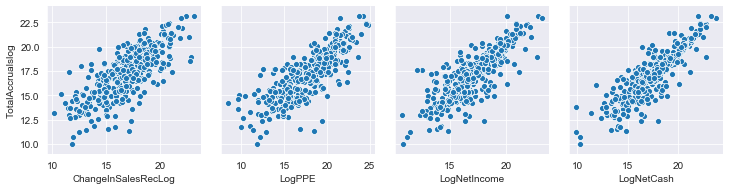

In [436]:
sns.pairplot(df_feature_model, x_vars =['ChangeInSalesRecLog', 'LogPPE',
            "LogNetIncome", "LogNetCash"], y_vars = ['TotalAccrualslog'] )

 We can see that all of these variables repersent a linear trend in the relationship with total accruals. These logged variables have positive trends. One thing to note, is that I took the absolute values prior to logging because we cannot take the log of a negative number

In [358]:
all_nan_values = df.isnull().sum()[df.isnull().sum()  > 0].sort_values(ascending = False)
all_nan_values

Series([], dtype: int64)

Ensure our data has no null values prior to model preparation

### Model Preparation



We are choosing the features based on the equation in the feature engineering section. We chose to generate a new feature matrix consisting of all polynomial combinations of the features with degree less than or equal to the specified degree. Polynomial features provides the best approximation of the relationship between dependent and independent variable. 

In [496]:
features = ['ChangeInSalesRecLog', 'LogPPE',
            "LogNetIncome", "LogNetCash"]

In [497]:
poly = PolynomialFeatures(include_bias=False)

In [498]:
X_poly = poly.fit_transform(df[features])

In [499]:
df_poly = pd.DataFrame(X_poly, columns=poly.get_feature_names(features))

X variables are all the polynomial features and the target is the log of total accruals

In [500]:
X = df_poly
y = df['TotalAccrualslog']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .40,
                                                    random_state = 35)




### Modeling

#### Baseline Model

In [619]:
baseline = y_train.mean()
baseline

17.31673454580702

In [623]:

dummy = DummyRegressor(strategy = "mean")
dummy.fit(X_train, y_train)
dummy.predict(X)

dummy.score(X, y)

-0.0002413525560120977

#### Linear  Model 1



In [502]:
lr = LinearRegression()
lr.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [503]:
pred_train = lr.predict(X_train) 
                                      
pred_test = lr.predict(X_test)   

# Score it and round to 3 dp
print("Training Set R^2 Score is:", np.round(lr.score(X_train, y_train),3))
print("Testing Set R^2 Score is:", np.round(lr.score(X_test, y_test),3))

Training Set R^2 Score is: 0.886
Testing Set R^2 Score is: 0.762


In [577]:
cross_val_score(lr, X, y, cv= 5).mean()

0.8307179277462021

##### Analysis of Model 1.


It seems that 88,6% of the varaince of the data can be explained by the training model. And 76% of the variance of the data can be explained by the testing set. The limitation of this model is that it repersents slight overfitting. This could be due to the train test split and how the model is being trained. In addition the cross val score is quite high with .83

#### Model 2: Ridge Model

In [505]:
r_alphas = np.logspace(0, 5, 100)
# Generates 100 values equally between 0 and 5,
# then converts them to alphas between 10^0 and 10^5.

# Cross-validate over our list of ridge alphas.
ridge_model = RidgeCV(alphas=r_alphas, scoring='r2', cv=5)

# Fit model using best ridge alpha!
ridge_model = ridge_model.fit(X_train, y_train)

In [506]:
ridge_model.alpha_

46.4158883361278

In [507]:
print("Train Set R^2 Score is:", ridge_model.score(X_train, y_train))
print("Testing Set R^2 Score is:", ridge_model.score(X_test, y_test))

Train Set R^2 Score is: 0.882935497948887
Testing Set R^2 Score is: 0.756620119462555


In [578]:
cross_val_score(ridge_model, X, y, cv= 5).mean()

0.8274131117506759

In [508]:
ridge_model.coef_

array([ 0.03486379,  0.07605535,  0.09314471,  0.08438578, -0.01486648,
       -0.01991914, -0.00672046,  0.05897702,  0.01427041,  0.00451262,
       -0.01076405,  0.17138982, -0.32400182,  0.14822946])

In [509]:
best_features = [tup for tup in list(zip(ridge_model.coef_,X_test.columns)) if tup[0] != 0]
best_features.sort(reverse=False) #descending order
best_features

[(-0.3240018191516166, 'LogNetIncome LogNetCash'),
 (-0.019919141205141096, 'ChangeInSalesRecLog LogPPE'),
 (-0.01486647549865728, 'ChangeInSalesRecLog^2'),
 (-0.010764051970863366, 'LogPPE LogNetCash'),
 (-0.0067204601093581, 'ChangeInSalesRecLog LogNetIncome'),
 (0.004512615763382641, 'LogPPE LogNetIncome'),
 (0.014270407254266874, 'LogPPE^2'),
 (0.03486379111149145, 'ChangeInSalesRecLog'),
 (0.05897701661999129, 'ChangeInSalesRecLog LogNetCash'),
 (0.07605535435701667, 'LogPPE'),
 (0.0843857783350362, 'LogNetCash'),
 (0.0931447052351607, 'LogNetIncome'),
 (0.14822946213073365, 'LogNetCash^2'),
 (0.1713898199110625, 'LogNetIncome^2')]

##### Analysis of Model 2.


It seems that 88.29% of the varaince of the data can be explained by the training model. And 76% of the variance of the data can be explained by the testing set. The limitation of this model is that it repersents slight overfitting. The ridge model reperesents not zero out coeficients but it shows that some of the polynomial features are not zero. This could be due to the train test split and how the model is being trained. In addition the cross val score is quite high with .83

In [579]:
def plot_predictions(model_name, y_train_pred ,y_train_actual):
    plt.scatter(y_train_actual, y_train_pred, c = "blue", marker = "s", label = "Training data")
    plt.title("Regression Sales Price")
    plt.xlabel("$\hat{y}$ = Actual SalePrice($)")
    plt.ylabel("$y$ = Predicted SalePrice($)")
    plt.legend(loc = "upper left")
    plt.plot([y_train_actual.min(), y_train_actual.max()], [y_train_actual.min(), y_train_actual.max()], c='red')
    plt.tight_layout()

#### Model 3: KNN Regressor

In [510]:
pipe_knn = Pipeline([
    ('sc', StandardScaler(with_mean = False)),
    ('model', KNeighborsRegressor())
])

knn_params = {
    'model__n_neighbors': range(1,10),
    'model__metric': ['minkowski', 'Euclidean', 'DistanceMetric']
}

In [511]:
pipe_knn_gridsearch = GridSearchCV(pipe_knn,
                                knn_params ,
                                cv = 5,
                                scoring='r2',
                                verbose=1)

In [512]:
results_knn = pipe_knn_gridsearch.fit(X_train, y_train);

Fitting 5 folds for each of 27 candidates, totalling 135 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 135 out of 135 | elapsed:    0.4s finished


In [513]:
pipe_knn_gridsearch.best_params_

{'model__metric': 'minkowski', 'model__n_neighbors': 6}

In [514]:
train_score = pipe_knn_gridsearch.best_score_
print('Best TRAIN set accuracy: {:.4f}'.format(train_score))
test_score = pipe_knn_gridsearch.score(X_test, y_test)
print('Best TEST set accuracy: {:.4f}'.format(test_score))

Best TRAIN set accuracy: 0.8164
Best TEST set accuracy: 0.7123


In [570]:
cross_val_score(pipe_knn_gridsearch.best_estimator_, X, y, cv= 5).mean()

0.7823450935669071

##### Analysis of Model 3.


A simple implementation of KNN regression is to calculate the average of the numerical target of the K nearest neighbors.  Another approach uses an inverse distance weighted average of the K nearest neighbors. KNN regression uses the same distance functions as KNN classification. It seems that 81.64% of the varaince of the data can be explained by the training model. And 71% of the variance of the data can be explained by the testing set. The limitation of this model is that it repersents slight overfitting. The ridge model reperesents not zero out coeficients but it shows that some of the polynomial features are not zero. This could be due to the train test split and how the model is being trained. In addition the cross val score is quite high with .78.

#### Model 4:  Decision Tree

In [515]:
pipe_dt = Pipeline([
    ('sc', StandardScaler(with_mean = False)),
    ('model', DecisionTreeRegressor())
])

dt_params = {
   'model__max_depth': [1,3,10,20],
   'model__max_features' :[1,3,5,6,7,8,9,10.15,15,20]
}

In [516]:
pipe_dt_gridsearch = GridSearchCV(pipe_dt,
                                dt_params ,
                                cv = 5,
                                scoring='r2',
                                verbose=1)

In [517]:
results_decision = pipe_dt_gridsearch.fit(X_train, y_train)

Fitting 5 folds for each of 40 candidates, totalling 200 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.8s finished


In [518]:
train_score_dec = results_decision.best_score_
print('Best TRAIN accuracy: {:.4f}'.format(train_score_dec))
test_score_dec = results_decision.score(X_test, y_test)
print('Best TEST set accuracy: {:.4f}'.format(test_score_dec))

Best TRAIN accuracy: 0.7716
Best TEST set accuracy: 0.6770


In [571]:
cross_val_score(pipe_dt_gridsearch.best_estimator_, X, y, cv= 5).mean()

0.6654852341747685

##### Analysis of Model 4


Our decision tree model does a worse job in determining total accruals based on depth of our trees. As seen in the model the r2 of this model tremendously decreased compared to that of the linear regression and the knn. The model does a worse job on determining the split off points for important features and does not do too well on the testing set. The model does not perform well on the full dataset, looking at our cross val score, and its easily interpretable. We will test further trees to determine if we can achieve a better cross val score.

#### Model 5:  Bagged Decision Tree¶

In [519]:
pipe_bg = Pipeline([
    ('sc', StandardScaler(with_mean = False)),
    ('model', BaggingRegressor())
])

bg_params = {
   'model__n_estimators': range(10, 100, 10),
}

pipe_bg_gridsearch = GridSearchCV(pipe_bg,
                                bg_params ,
                                cv = 5,
                                scoring='r2',
                                verbose=1)

In [520]:
results_bagging = pipe_bg_gridsearch.fit(X_train, y_train)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 5 folds for each of 9 candidates, totalling 45 fits


[Parallel(n_jobs=1)]: Done  45 out of  45 | elapsed:    3.9s finished


In [521]:
train_score_bag = results_bagging.best_score_
print('Best TRAIN accuracy: {:.4f}'.format(train_score_bag))
test_score_bag = results_bagging.score(X_test, y_test)
print('Best TEST set accuracy: {:.4f}'.format(test_score_bag))

Best TRAIN accuracy: 0.8160
Best TEST set accuracy: 0.7080


In [573]:
cross_val_score(pipe_bg_gridsearch.best_estimator_, X, y, cv= 5).mean()

0.7889448621085877

##### Analysis of Model 5


Our bagging model does a better job in determining total accruals based on depth of our trees. As seen in the model the r2 of this model slightly decreased compared to that of the linear regression and the knn, but increased against decision trees. The model performs better on the full dataset than decision trees,looking at our cross val score,the model explains 78% of the variance of the data on the full dataset. We will test further trees to determine if we can achieve a better cross val score.

#### Model 6: Random Forests¶

In [522]:
pipe_rf = Pipeline(steps = [ ('sc', StandardScaler()),
                          ('rf', RandomForestRegressor())
                         
                        ])    

# Construct Grid Parameters
hyperparams = {
               
               
                                                        # use a single value that isn't built into
                                                        # the defaults (otw: stopwords left in
               'rf__n_estimators': [100, 150, 200],
               'rf__max_depth': [None, 1, 2, 3, 4, 5],
}
                
              

 # Perform Grid Search
gs_rf = GridSearchCV(pipe_rf, # pipeline object replaces what we usually had as empty model class
                 param_grid=hyperparams,
                 cv = 5,
                 scoring = 'r2')


In [523]:
results_rf= gs_rf.fit(X_train, y_train)

In [524]:
train_score_rf = results_rf.best_score_
print('Best TRAIN accuracy: {:.4f}'.format(train_score_rf))
test_score_rf = results_rf.score(X_test, y_test)
print('Best TEST set accuracy: {:.4f}'.format(test_score_rf))

Best TRAIN accuracy: 0.8122
Best TEST set accuracy: 0.7192


In [574]:
cross_val_score(gs_rf.best_estimator_, X, y, cv= 5).mean()

0.7932043249487001

##### Analysis of Model 6

We decided to test random forest. As the r2 score was slightly higher than bagging and decision trees, the model also did better on the full data set. This model does not compare to linear regression and we will not be using the random forest

#### Model 7: Ada Boost Model

In [525]:
pipe_ab = Pipeline(steps = [ ('sc', StandardScaler()),
                         ('ab',AdaBoostRegressor(base_estimator=DecisionTreeRegressor()))
                         
                        ])    

# Construct Grid Parameters
hyperparams = {
               
               
                                                        # use a single value that isn't built into
                                                        # the defaults (otw: stopwords left in
               'ab__n_estimators': [50,100],
               'ab__base_estimator__max_depth': [1,2],
               'ab__learning_rate': [.9, 1.]
}
                
              

 # Perform Grid Search
gs_ab = GridSearchCV(pipe_ab, # pipeline object replaces what we usually had as empty model class
                 param_grid=hyperparams,
                 cv = 3,
                 scoring = 'r2')


In [526]:
results_ab = gs_ab.fit(X_train, y_train)
train_score_ab = results_ab.best_score_
print('Best TRAIN accuracy: {:.4f}'.format(train_score_ab))
test_score_ab = results_ab.score(X_test, y_test)
print('Best TEST set accuracy: {:.4f}'.format(test_score_ab))


Best TRAIN accuracy: 0.7342
Best TEST set accuracy: 0.5878


In [575]:
cross_val_score(gs_ab.best_estimator_, X, y, cv= 5).mean()

0.6644870318504912

##### Analysis of Model 7

We decided to test ada boost. The r2 score was the worst performing and we will decide to test svr

#### Model 8: Support Vector Machine¶

In [527]:
svr = svm.SVR()
svr.fit(X_train, y_train)


SVR(C=1.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma='scale',
    kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False)

In [528]:
pipe_svm = Pipeline([
    ('sc', StandardScaler(with_mean = False)),
    ('model', svm.SVR())
])

svm_params = {
   'model__C': [1,3,10,100],
   'model__epsilon' : range(0,1)
}

gs_svm = GridSearchCV(pipe_svm, # pipeline object replaces what we usually had as empty model class
                 param_grid=svm_params,
                 cv = 3,
                 scoring = 'r2')

In [529]:
results_svm = gs_svm.fit(X, y)
train_score_svm = results_svm.best_score_
print('Best TRAIN accuracy: {:.4f}'.format(train_score_svm))
test_score_svm = results_ab.score(X_test, y_test)
print('Best TEST set accuracy: {:.4f}'.format(test_score_svm))

Best TRAIN accuracy: 0.8251
Best TEST set accuracy: 0.5878


In [624]:
cross_val_score(gs_svm.best_estimator_, X, y, cv= 5).mean()

0.8201693631773195

##### Analysis of Model 8

We decided to test ada svr. The r2 score performed really well on the train set, but it did not on the test set. This model shows high overfitting. The model's cross val score does the best on the whole data set compared to all the models. The Linear Model is much easier to interpret as the SVR is a black box model.

## Model Selection

|Model|Type|Train R2|Testing R2|
|---|---|---|---|
|**Model 1**|*Linear*|0.886|0.762| 
|**Model 2**|*Ridge*|.883|0.757|
|**Model 4**|*KNN Regressor*|.0.816|.712|
|**Model 5**|*Decision Trees*|.0.772|.677|
|**Model 6**|*Bagged Decision Trees*|.816|.708|
|**Model 7**|*Random Forrest Trees*|.812|.719|
|**Model 8**|*SVM*|.8251|.5878|





Based on R2 scores listed above, We have decided to choose model 1 to deliver to our audit team in predicting total net accruals. This model will be best suited for our auditors to prepare for year end audit planning in the for the 2016 audit during election time. Model 1 does the best in predicting total accrual prices, and more of the variance in the data can be explained by our model. We want to deliver high level tax solutions to our clients with the least amount of residuals.

## Model Evaluation

### Linear Stats Model: Interpetation of Pvalues and Coeficients

In [607]:
model_accruals = linear_model.LinearRegression(fit_intercept = True)
TotalNetAccruals = df['TotalAccrualslog']
x = df[features]
x_constant = sm.add_constant(x)
model_accruals = sm.OLS(TotalNetAccruals, x_constant).fit()
model_accruals.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:       TotalAccrualslog   R-squared:                       0.804
Model:                            OLS   Adj. R-squared:                  0.802
Method:                 Least Squares   F-statistic:                     414.8
Date:                Mon, 09 Mar 2020   Prob (F-statistic):          9.76e-142
Time:                        14:31:41   Log-Likelihood:                -595.47
No. Observations:                 410   AIC:                             1201.
Df Residuals:                     405   BIC:                             1221.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                   1.0731      0.430      2.496      0.013       0.228       1.918
ChangeInSalesRecLog     0.1169      0.037      3.140      0.002       0.044       0.190
LogPPE                  0.1630      0.032      5.101      0.000       0.100       0.226
LogNetIncome            0.2102      0.047      4.451      0.000       0.117       0.303
LogNetCash              0.4379      0.050      8.797      0.000       0.340       0.536
==============================================================================
Omnibus:                      124.737   Durbin-Watson:                   2.094
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              369.566
Skew:                          -1.418   Prob(JB):                     5.62e-81
Kurtosis:                       6.686   Cond. No.                         294.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Results
I created the regression model based off the 2016 We trained this model to find a goodness of fit and coefficients to show the relationships between total accruals to the 5 variables used in both models. 

2016 actual model analysis: We use a Regression Analysis to see how closley related independent variables are to dependent variables. "The result of pulling discretionary accrual amounts from the total accrual amount is a metric that reflects accruals that are due to management's choices alone; in other words, there appears to be no business reason for these accruals. So, discretionary accruals are a better proxy for earnings quality." We want to predict total net accruals(non discretionary) for companies based off certain independent variables. To estimate non discretionary accrual amounts, we use a time series analysis. We look at data over a period of time. This model is created based off the 2016 period and the lagged variables are the prior period. An error term is a variable that shows a misrepresentation in the relationship between the independent and dependent variable. An error term in this case is represeneted by discretionary accruals. The higher the discretionary accruals the lower the quality of earnings. Inputs Variables: Dependent Variables: Total NET ACCRUALS The Dependent variable is the variable that is being tested. We are creating our model based of 410 observations in 2016 Independent Variables: ChangeinSalesRecLog, LogPPE, LogNetIncome, LogNetCash

As you can see from above we use lag variables to find the prior year assets

Created a regression model to test total net accruals, based off 4 variables; ChangeinSalesRecLog, LogPPE, LogNetIncome, LogNetCash. We want to use this model to predict total net accruals for firms and check the error rate to see managements decisions on accruals. The adjusted R squared value in this model is .802. R squared is the fraction of variation in your predicted variable in relation to your independent variable. That means that the closer the model is to 100%, explains that all the variablity is around the average. Based off these 410 observations, the model shows that 80.2 percent of the variance data is explained by this model . As you see from, the predictions based off the model shows that the predicted total net accruals are closley related to the actual net accruals. Regression coefficients represents the mean change in the response variable for one unit of change in the independent variable. LogNetCash has a coefficient of .44, which indicates that for every additional net cash operating you can expect Total Net Accruals log to increase by an average of .437 dollars.


### Goodness of Fit:

As you can see from the r squared, of .802, that the explained variation/total variation is approx 80.02 percent. The actual model had 410 observations, which could be an explanation behind the 80.02 r squared value. The closer to 100%, the less variation in the model. As you can see from the predicted observations from above, I compared the first 4 of the predicted observations to the actual observations to see the realibility of the model. The first 4 predicted net accrual amount are:

You can see there are variations between the predicted observations and actual observations, but thats due to the fact that the model only explains 80.02% of the variations.

The first observation that I found is the return on assets coefficient value. To get a better r squared value, I did different variations of the jones model and I dropped the ones with the lowest coeficients. Return on assets is a f/s ratio that I used in the model that I dropped due to the lack of predictive power.

The second observation that I found is the signifcance of the p values in both models. The higher the p value, represents the changes in the predictor is not responsive. The common alpha value is .05 and if it is greater than .05 indicates that the variable is not statistically significant. A predictor that has a low p value represents greater responsivness between changes in the tested variable. All variables showed perfect responsivness to total accruals and should be used predict the model. If given more time I would love to test depreciation expense, and lagging cash flow items to find differences in cf from operations. 

Based off the p values and the change in r squared I decided to not make any changes to the model for further testing. I will test total net accruals based off the variables that have low p values. If given more time, I would test depreciation and inventory to see its affect on Total Net Accruals.The model is going to be used to test future net accruals in the 2017 quarter 3 periods. We are going to look at if the predicted values are too high, too low, or equal to the actual observations.

In [610]:
def plot_predictions(model_name, y_train_pred ,y_train_actual):
    plt.figure(figsize= (12,12))
    plt.scatter(y_train_actual, y_train_pred, c = "blue", marker = "s", label = "Testing Data")
    plt.title("Predicted vs Actual Accruals", fontsize = 24)
    plt.xlabel("$\hat{y}$ = Actual Total Accruals($)", fontsize = 20)
    plt.ylabel("$y$ = Predicted Accruals($)", fontsize = 20)
    plt.legend(loc = "upper left")
    plt.gcf().axes[0].yaxis.get_major_formatter().set_scientific(False)
    plt.gcf().axes[0].xaxis.get_major_formatter().set_scientific(False)
    plt.plot([y_train_actual.min(), y_train_actual.max()], [y_train_actual.min(), y_train_actual.max()], c='red')
    plt.tight_layout()

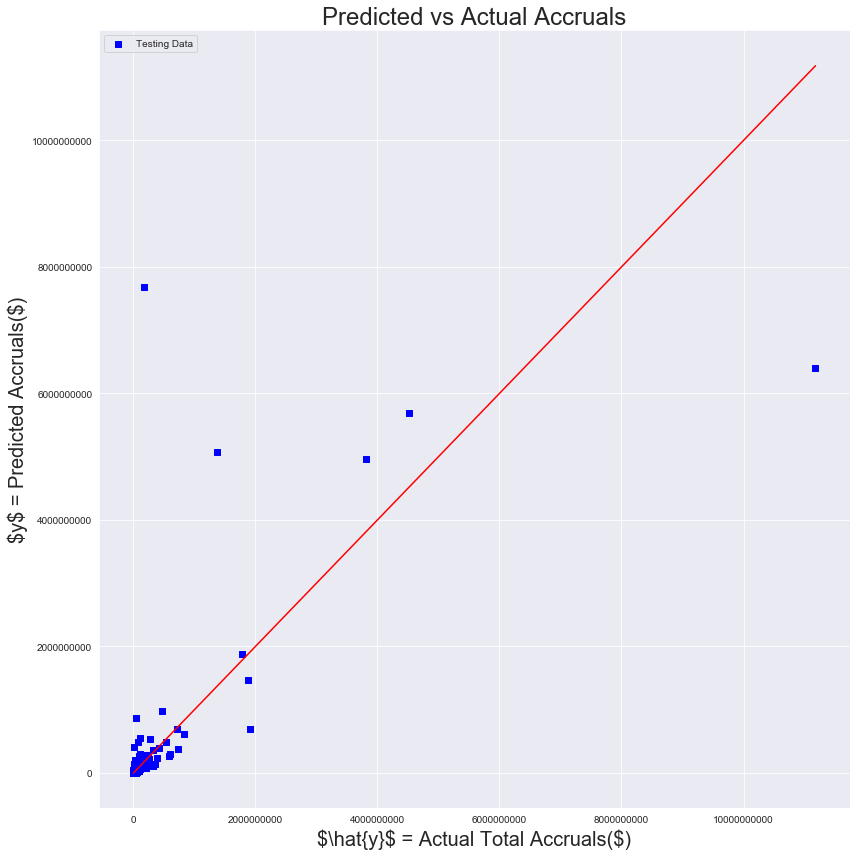

In [611]:
plot_predictions(lr,np.exp(pred_test), np.exp(y_test))

In [601]:
residuals_1 = np.exp(y_test)- np.exp(pred_test)

Text(0.5, 1.0, 'Model 1 Residuals by Total Accruals')

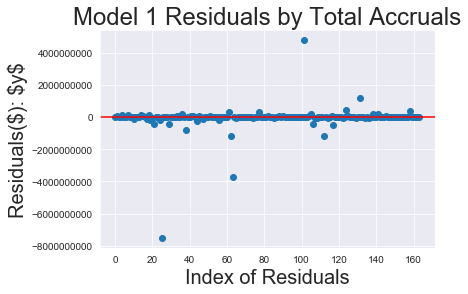

In [603]:
plt.scatter(range(len(residuals_1)), residuals_1)
plt.axhline(0,color = 'red')
plt.xlabel("Index of Residuals", fontsize = 20)
plt.ylabel("Residuals($): $y$", fontsize = 20)
plt.gcf().axes[0].yaxis.get_major_formatter().set_scientific(False)
plt.title('Model 1 Residuals by Total Accruals', fontsize = 24)

### Validate Predictions on 2017 Q3 DataSet


Do the same as the training set to validation set

In [530]:
num4 =  pd.read_csv('./data/2017q3/num.txt', sep = '\t', encoding="latin-1")
tag4 =  pd.read_csv('./data/2017q3/tag.txt', sep = '\t', encoding="latin-1")
pre4 =  pd.read_csv('./data/2017q3/pre.txt', sep = '\t', encoding="latin-1")
sub4 =  pd.read_csv('./data/2017q3/sub.txt', sep = '\t', encoding="latin-1")

Merge on same unique identifiers

In [531]:
firstmerge4 = pd.merge(pre4, sub4, how = "left", on=['adsh'])   #left merge
secondmerge4 = pd.merge(firstmerge4, tag4, how= "inner", on =['tag', 'version'])
thirdmerge4 = pd.merge(secondmerge4, num4, how = "inner", on =['adsh', 'tag', 'version'])
sec_data2017 = thirdmerge4[['cik','adsh' , 'afs' , 'qtrs' , 'fy' , 'fp', 'tag', 'version', 'value' , 'ddate']].sort_values(['cik'])

,cik,adsh,afs,qtrs,fy,fp,tag,version,value,ddate
158530,1750,0001047469-17-004528,1-LAF,0,2017.0,FY,DeferredTaxLiabilitiesNoncurrent,us-gaap/2016,3.720000e+07,20170531
73518,1750,0001104659-17-058003,1-LAF,0,2018.0,Q1,CashAndCashEquivalentsAtCarryingValue,us-gaap/2016,7.900000e+06,20160831
73517,1750,0001104659-17-058003,1-LAF,0,2018.0,Q1,CashAndCashEquivalentsAtCarryingValue,us-gaap/2016,3.120000e+07,20160531
73516,1750,0001104659-17-058003,1-LAF,0,2018.0,Q1,CashAndCashEquivalentsAtCarryingValue,us-gaap/2016,1.510000e+07,20170831
73515,1750,0001104659-17-058003,1-LAF,0,2018.0,Q1,CashAndCashEquivalentsAtCarryingValue,us-gaap/2016,1.030000e+07,20170531
...,...,...,...,...,...,...,...,...,...,...
1504508,1712041,0001615774-17-004906,5-SML,2,2017.0,Q2,RepaymentsOfNotesPayable,us-gaap/2017,2.544000e+03,20170630
1504509,1712041,0001615774-17-004906,5-SML,4,2017.0,Q2,RepaymentsOfNotesPayable,us-gaap/2017,5.477200e+04,20161231
1504510,1712041,0001615774-17-004906,5-SML,4,2017.0,Q2,RepaymentsOfNotesPayable,us-gaap/2017,NaN,20151231
982100,1712041,0001615774-17-004906,5-SML,2,2017.0,Q2,GeneralAndAdministrativeExpense,us-gaap/2017,4.706800e+04,20160630


Call get tags function created earlier. Great function for generalization

In [532]:
Regression_2017 = get_tags(sec_data2017,'NetIncomeLoss','NetCashProvidedByUsedInOperatingActivities','SalesRevenueNet','Assets',
'AccountsReceivableNetCurrent','PropertyPlantAndEquipmentNet')

Call Engineer Function to filter out by 3q

In [533]:
Regression_Q317 = engineer_tags(Regression_2017, 20170630, 20160630)

Make sure to log all features like training set

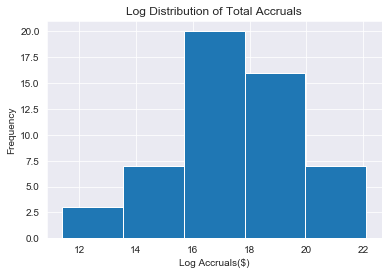

In [535]:
log_numeric_column(Regression_Q317, "TotalNetAccruals", 'TotalAccrualslog', 
                   "Log Distribution of Total Accruals", "Log Accruals($)")

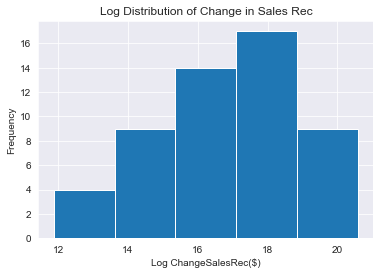

In [536]:
log_numeric_column(Regression_Q317, 'ChangeSalesRec', 'ChangeInSalesRecLog', 
                   "Log Distribution of Change in Sales Rec", "Log ChangeSalesRec($)")

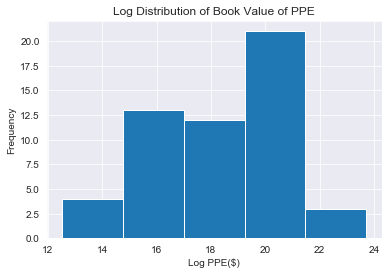

In [537]:
log_numeric_column(Regression_Q317, 'PropertyPlantAndEquipmentNet', 'LogPPE', 
                   "Log Distribution of Book Value of PPE", "Log PPE($)")

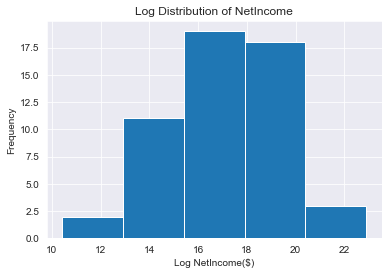

In [539]:
log_numeric_column(Regression_Q317, 'NetIncomeLoss', 'LogNetIncome', 
                   "Log Distribution of NetIncome" , "Log NetIncome($)")

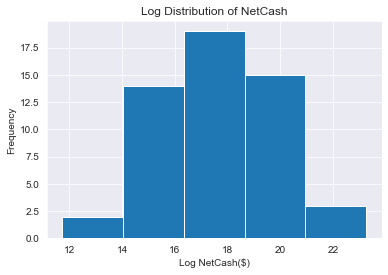

In [540]:
log_numeric_column(Regression_Q317, 'NetCashProvidedByUsedInOperatingActivities', 'LogNetCash', 
                   "Log Distribution of NetCash" , "Log NetCash($)")

Make sure to create poly features just like training set.

In [541]:
features = ['ChangeInSalesRecLog', 'LogPPE',
            "LogNetIncome", "LogNetCash"]

In [542]:
poly = PolynomialFeatures(include_bias=False)

In [543]:
X_poly = poly.fit_transform(Regression_Q317[features])

In [544]:
df_poly_17 = pd.DataFrame(X_poly, columns=poly.get_feature_names(features))

Use the linear model to predict total accruals on validation set

In [551]:
linear_val= lr.predict((df_poly_17))

Create Data frame of variance, expected average, and predicted accruals vs actual accruals

In [568]:
df_linear_bag = pd.DataFrame(np.exp(linear_val), columns = ['Predicted2017Q3Accruals'])
df_linear_bag['TotalAccruals'] = list(Regression_Q317['TotalNetAccruals'])
df_linear_bag['Variance'] = df_linear_bag['Predicted2017Q3Accruals'] - df_linear_bag['TotalAccruals']
df_linear_bag['ExpectedAverage(%)'] = df_linear_bag['Variance']/ df_linear_bag['Predicted2017Q3Accruals']  * 100
df_linear_bag = df_linear_bag.sort_values(by = 'Variance', ascending = True)

In [560]:
high_variance = df_linear_bag[(df_linear_bag['ExpectedAverage(%)'] < -40)]
print('Percentages lower than -40% of the data' , len(high_variance))

Percentages lower than -40% of the data 19


See which values were greater than the actual

In [562]:
high_amount = df_linear_bag[(df_linear_bag['Variance'] > 0)]
high_amount.head()

,Predicted2017Q3Accruals,TotalAccruals,Variance,ExpectedAverage(%)
19,2.008940e+06,1849000.0,159939.865277,7.961406
29,3.771017e+05,216000.0,161101.678501,42.721019
3,1.784655e+06,1520394.0,264260.712476,14.807386
41,3.527719e+06,3124964.0,402754.738414,11.416861
7,3.046247e+07,29966000.0,496468.139226,1.629770


See which values are lower than the actual

In [567]:
low_amount = df_linear_bag[(df_linear_bag['Variance'] < 0)]
low_amount.head()

,Predicted2017Q3Accruals,TotalAccruals,Variance,ExpectedAverage(%)
48,4.006263e+08,1.077500e+09,-6.768737e+08,-168.953913
40,9.447602e+08,1.144000e+09,-1.992398e+08,-21.088934
0,9.349504e+08,1.126300e+09,-1.913496e+08,-20.466280
42,9.900072e+07,2.099425e+08,-1.109418e+08,-112.061597
51,5.912525e+07,1.637000e+08,-1.045748e+08,-176.869868


In [566]:
exact_amount = df_linear_bag[(df_linear_bag['Variance'] == 0)]

We did not predict one company correctly. We are in the ballpark for some companies. The purpose of audits is to provide reasonable assurance that companies are stating its accruals with the fair representation of its financial statements.

We took the percentage of the varaince over the actual amounts to compare and see how close the percentage change is to 0. I took -40% as a threshold to see how many percentages fall below 40%. We found that 19 of the 54 of the observations fell below this threshold, which shows that over 65% of the data shows a high amount of variance. When there is a high level of variance in a model in the model, it shows that new variables should be implemented to better test total accruals. The validation set is great for explicitly showing the deployment of our model in the audit process. The fact that most values are within 6 figures shows that we can deploy our model for certain companies. I want to examine the 3 averages closer to 0 and the 3 averages farthest from 0 to see which types of companies are throwing off our model.

## Conclusion
In conclusion, the jones model is a way for companies to predict non discretionary accruals across firms using time series data. Being able to extract industry wide financial data, and predict future companys amounts based off multiple regression. We want to be able to find relationships between relationships, and create models to help conclude on hypothesis and test variables that are in interest of management. If we were to audit big companies, we could use financial data for individual customers to predict certain financial information based off prior data. Although, our model has a lot of variance, that comes to show that we have to continue to find new variables to test to find the least amount of variance. We can look at p values that are lower than .05 which will show the level of responsivness for certain variables. We saw, on average, that the change in revenues and change in accounts recievables have the biggest effect on the change in accruals. We see in many fraud cases, that trends in recievables and sales can be examined to see any overstatements in receivables and revenue. If given more time as our busy season is starting, we want to add non cash financing activites, like depreciation, as variables into the model to see if there is any relationship to accruals. Many companies have different ways to identify tags in the database, so it is useful to extract data from the sec taxonomy to see the most frequent tags used in the industry. This will allow us analysts to find more relationships in accruals across the industry

## Recommendations

The Recommendations to improve the model is to add more non cash financing activities such as depreciation, ammortization, and ppe gains and losses. When fitting the model, we are using X features without taking into account GAAP laws and other factors that affect earnings managmenet. Predicting Accruals is a great way to get a nice understanding of what we can expect in the following year. Our audit team will use professional skepticsm in determining high volume accounts. We want to highlight what affects accruals, and how we can predict accruals in order to give a proper scope to our audit team. 